# Autocorrelation for Glauber dynamics on homogeneous graph

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Printf, Statistics, ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [48]:
T = 20
N = 30
k = 3
gg = random_regular_graph(N, k)
# gg = SimpleGraph(prim_mst(gg)); @assert is_connected(gg)
g = IndexedGraph(gg)
p⁰ = fill([0.75, 0.25], N)

gl = Glauber(Ising(g), T; p⁰);

In [49]:
bp = mpbp(gl)
cb = CB_BP(bp);

In [20]:
svd_trunc = TruncBond(10)
iters, cb = iterate!(bp, maxiter=200; svd_trunc, cb, tol=1e-4)
@show iters
b_bp = beliefs(bp)
m_bp = belief_expectations(bp);

Running MPBP: iter 12 	 Time: 0:01:32
  Δ:  6.36119921059719e-5

iters = 12


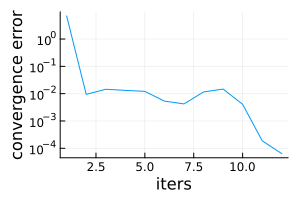

In [21]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="")

In [64]:
sms = SoftMarginSampler(bp);

In [68]:
ns = 10^6
sms = sample!(sms, ns);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:06:4839m


In [72]:
b_mc = marginals(sms)
m_mc = [[bbb[1]-bbb[2] for bbb in bb] for bb in b_mc];

Max matrix size: 10x10


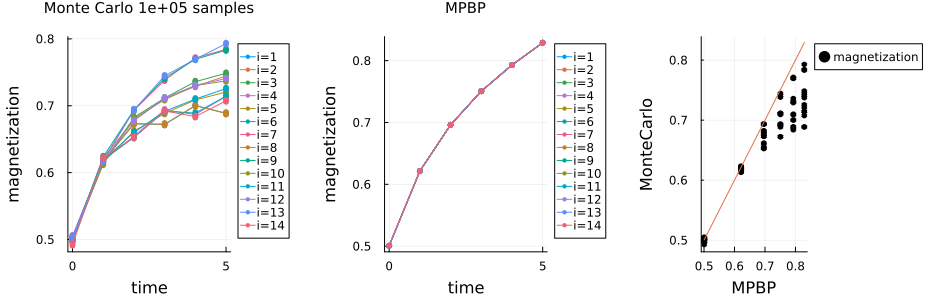

In [23]:
title = @sprintf "Monte Carlo %.0e samples" ns
pl_mc = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title=title)
for i in 1:N
    plot!(pl_mc, 0:T, m_mc[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, m_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_sc = scatter(reduce(vcat, m_bp), reduce(vcat, m_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="magnetization", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [ ]:
c = autocovariances(sms);

In [ ]:
using ColorSchemes
i = 3
ci = c[i]
us = 2:2:(T-1)
cg = cgrad(:matter, length(us), categorical=true)
pl = plot(xlabel="u-t", ylabel="autocovariance"*"\$<\\sigma_i^t\\sigma_i^u>-<\\sigma_i^t><\\sigma_i^u> \$", legend=:outertopright)
for (j,u) in enumerate(us)
    plot!(pl, 1:u-1, ci[2:u,u+1], label="u=$u", m=:o, c=cg[j]) 
end
pl